In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
model = Chain(Dense(1=>20, relu), Dense(20=>1))
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev
x = rand(Float32, 1, 50) |> gdev
y = model(x, ps, st)  # Check for errors here

(Float32[-0.3890604 -0.38254273 … -0.36488163 -0.3933931], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [12]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

(Float32[0.43635908 -0.02072694 … -0.014802111 -0.0019893101; -0.17784306 0.30380124 … -0.07276908 -0.0056274263], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [13]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)),)
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

# function build_mlp(args)
#     phasor_model = Chain(LayerNorm((2,)), x -> tanh.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
#     ps, st = Lux.setup(args.rng, phasor_model)
#     return phasor_model, ps, st
# end

build_mlp (generic function with 1 method)

In [14]:
x = x |> gdev

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [19]:
size(x)

(2, 256)

In [34]:
model = Chain(BatchNorm(2))#, Dense(2=>20, relu),  Dense(20=>10),)
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev

((layer_1 = (scale = Float32[1.0, 1.0], bias = Float32[0.0, 0.0]),), (layer_1 = (running_mean = Float32[0.0, 0.0], running_var = Float32[1.0, 1.0], training = Val{true}()),))

In [35]:
model(x, ps, st)

LoadError: Not implemented

In [ ]:
model_f, ps_f, st_f = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()),), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]),), (layer_1 = NamedTuple(),))

In [ ]:

ps_f = ps_f |> gdev
st_f = st_f |> gdev

(layer_1 = NamedTuple(),)

In [22]:
tanh.(x)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
 -0.0240879   -0.0310632  -0.177714  …  -0.21139   -0.348879  0.00891883
  0.00118548  -0.0123505  -0.318558     -0.299729  -0.233423  0.00743606

In [23]:
y_f, _ = model_f(x, ps_f, st_f)

LoadError: Not implemented

In [ ]:
function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

In [44]:
spk_model_f, _, _ = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#47#48"}, layer_3::MakeSpiking, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#47), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0f0), 0.0), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025231287 -0.038644426; -0.008006413 0.22121298; … ; 0.08021294 0.15149581; 0.1500836 0.10625532], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0

In [ ]:
size(y_f)

In [ ]:
y_f, _ = model_f(x, ps_f, st_f)

In [18]:
import .PhasorNetworks: phase_to_train

In [19]:
ts = phase_to_time(x, spk_args=spk_args, offset=0.0f0)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.71818   0.489637  0.522201  0.497411  …  0.503094  0.492599  0.499005
 0.411078  0.651901  0.481702  0.49723      0.498118  0.463615  0.497186

In [20]:
shape = x |> size
indices = collect(CartesianIndices(shape)) |> vec

512-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 1)
 CartesianIndex(1, 2)
 CartesianIndex(2, 2)
 CartesianIndex(1, 3)
 CartesianIndex(2, 3)
 CartesianIndex(1, 4)
 CartesianIndex(2, 4)
 CartesianIndex(1, 5)
 CartesianIndex(2, 5)
 CartesianIndex(1, 6)
 CartesianIndex(2, 6)
 CartesianIndex(1, 7)
 ⋮
 CartesianIndex(1, 251)
 CartesianIndex(2, 251)
 CartesianIndex(1, 252)
 CartesianIndex(2, 252)
 CartesianIndex(1, 253)
 CartesianIndex(2, 253)
 CartesianIndex(1, 254)
 CartesianIndex(2, 254)
 CartesianIndex(1, 255)
 CartesianIndex(2, 255)
 CartesianIndex(1, 256)
 CartesianIndex(2, 256)

In [21]:
ts |> length

512

In [22]:
import .PhasorNetworks: phase_to_train

In [23]:
typeof(x) <: CuArray

true

In [24]:
function phase_to_train(phases::CuArray; spk_args::SpikingArgs, repeats::Int = 1, offset::Real = 0.0f0)
    shape = phases |> size
    indices = collect(CartesianIndices(shape)) |> vec
    times = phase_to_time(phases, spk_args=spk_args, offset=offset) |> vec

    if repeats > 1
        n_t = times |> length
        offsets = cu(repeat(collect(0:repeats-1) .* spk_args.t_period, inner=n_t))
        times = repeat(times, repeats) .+ offsets
        indices = repeat(indices, repeats)
    end

    train = SpikeTrainGPU(indices, times, shape, offset)
    return train
end

phase_to_train (generic function with 2 methods)

In [25]:
a = phase_to_train(x, spk_args=spk_args, repeats=10, offset=0.0f0)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 252), CartesianIndex(2, 252), CartesianIndex(1, 253), CartesianIndex(2, 253), CartesianIndex(1, 254), CartesianIndex(2, 254), CartesianIndex(1, 255), CartesianIndex(2, 255), CartesianIndex(1, 256), CartesianIndex(2, 256)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120], Float32[0.7181795, 0.41107845, 0.48963654, 0.65190065, 0.5222008, 0.48170218, 0.49741074, 0.4972299, 0.46343565, 0.50226045  …  9.315895, 9.582314, 9.510534, 9.509322, 9.503094, 9.498118, 9.492599, 9.463615, 9.499005, 9.497187], (2, 256), 512, 0.0f0)

In [16]:
y_spk_f.train.offset

0.5

In [17]:
p_spk_f = train_to_phase(y_spk_f);

In [18]:
size(p_spk_f)

(10, 2, 256)

In [19]:
size(y_f)

(2, 256)

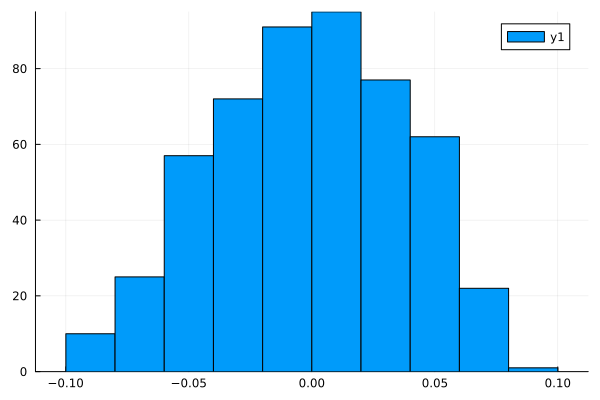

In [20]:
histogram(vec(p_spk_f[5,:,:]))

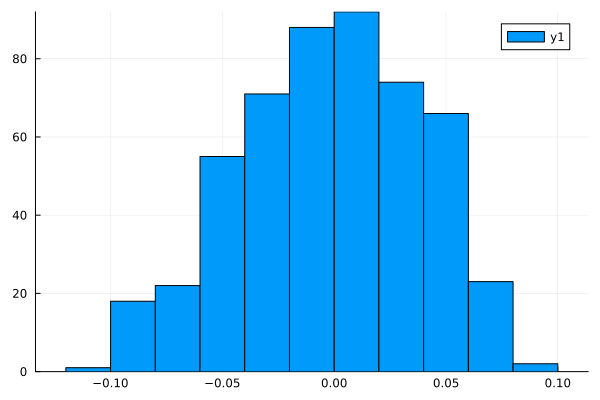

In [21]:
histogram(vec(p_spk_f[6,:,:]))

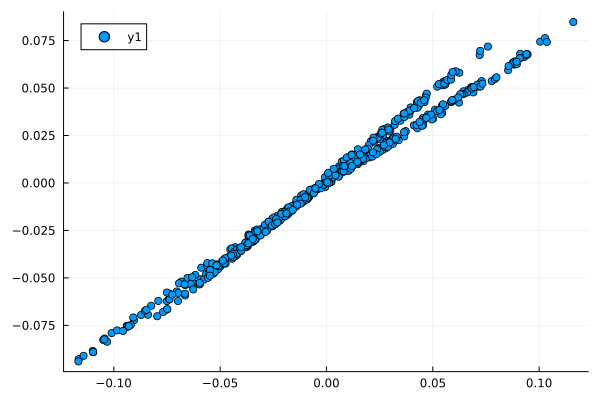

In [22]:
scatter(vec(y_f), vec(p_spk_f[5,:,:]))

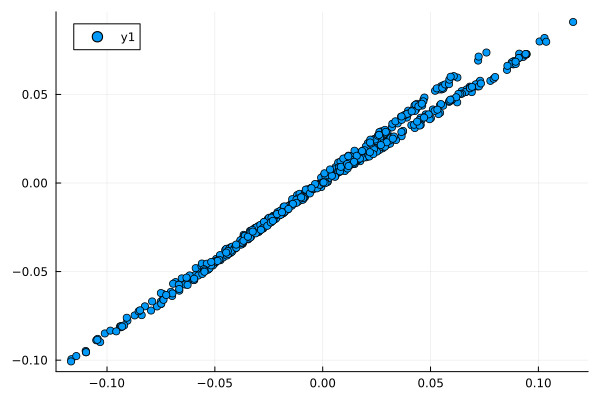

In [23]:
scatter(vec(y_f), vec(p_spk_f[6,:,:]))

In [24]:
cycle_correlation(y_f, p_spk_f)

10-element Vector{Float64}:
 NaN
   0.9574926180865236
   0.9827656087091672
   0.9911054153162355
   0.9945394086500386
   0.9961571724700357
   0.9969892714369741
   0.9974438152049062
   0.9977029173522644
   0.9883285067094865

In [24]:
losses_f, ps_train_f, st_train_f = train(model_f, ps_f, st_f, train_loader, args)

[ Info: Training on CPU


(Any[0.49872121134692143, 0.5211221973435561, 0.5082742474195519, 0.5136231831737799, 0.4943845354082511, 0.49740236463324033, 0.4872463266986948, 0.481221219549921, 0.48914629204794935, 0.4815789206296046  …  0.0568530273633278, 0.04347768528300689, 0.045888754199539736, 0.04510184537587257, 0.061042395060813236, 0.049483366029535035, 0.054607927545205576, 0.05410345407506266, 0.06503692399941924, 0.05217629091596032], (layer_1 = (bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.04173581 0.011097611; 0.007310995 -0.098167986; … ; 0.15090613 -0.018089933; -0.24436979 0.022904145], bias_real = Float32[0.9893609, 1.0206473, 1.0272624, 0.9854006, 0.8565414, 0.9733166, 0.9726222, 0.98102, 0.9935856, 0.97464263  …  0.9867618, 1.0006989, 1.0331075, 1.020813, 0.98554134, 1.0059948, 0.9812722, 0.9916397, 1.0107608, 0.9958822], bias_imag = Float32[-0.0050614476, -0.0040287124, 0.0

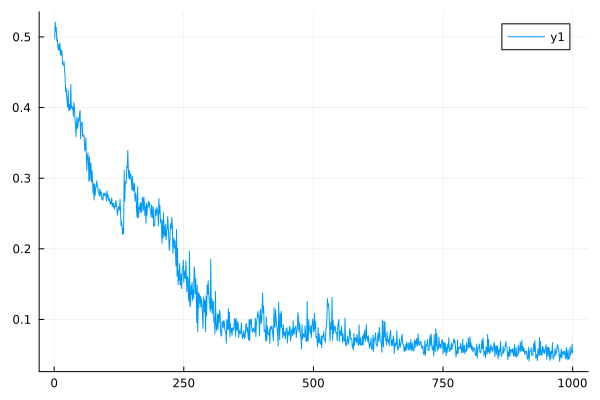

In [25]:
plot(losses_f)

In [26]:
loss_and_accuracy(test_loader, model_f, ps_train_f, st_train_f)

(0.05066728205196651, 0.973828125)

In [27]:
ps_train_f.layer_1

(bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;])

In [28]:
yt_f, _ = model_f(x, ps_train_f, st_train_f)

([-0.06431134566450077 0.10651670865384275 … 0.5060976718095738 0.5578967142335515; 0.39281427269815455 0.4373721880071353 … 0.11791260437980783 0.024660960856190333], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [29]:
ps_train_f

(layer_1 = (bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.04173581 0.011097611; 0.007310995 -0.098167986; … ; 0.15090613 -0.018089933; -0.24436979 0.022904145], bias_real = Float32[0.9893609, 1.0206473, 1.0272624, 0.9854006, 0.8565414, 0.9733166, 0.9726222, 0.98102, 0.9935856, 0.97464263  …  0.9867618, 1.0006989, 1.0331075, 1.020813, 0.98554134, 1.0059948, 0.9812722, 0.9916397, 1.0107608, 0.9958822], bias_imag = Float32[-0.0050614476, -0.0040287124, 0.0074766246, -0.014946235, 0.109835275, 0.0017270701, -0.027147572, 0.056947954, -0.00028140467, -0.010189336  …  -0.03223262, -0.036699872, -0.0041815965, 0.00930367, -0.00264803, 0.0015649532, -0.01621104, 0.02037809, 0.016045837, -0.02900312]), layer_5 = (weight = Float32[0.12459448 -0.12286748 … -0.122526824 -0.13777; -0.055697106 -0.06724836 … -0.027451849 0.09509349], bias_real = Float32[0.99746597, 0.9874371], bias_

In [30]:
yt_spk_f, _ = spk_model_f(x, ps_train_f, st_train_f)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [31]:
pt_f = train_to_phase(yt_spk_f.train, spk_args=spk_args);

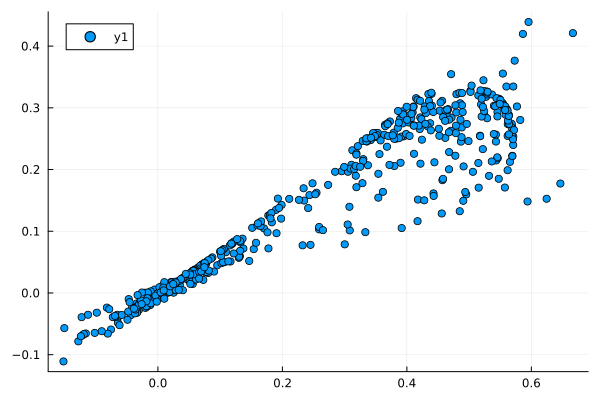

In [32]:
scatter(vec(yt_f), vec(pt_f[end-1,:,:]))

In [33]:
cycle_correlation(yt_f, pt_f)

10-element Vector{Float64}:
 0.006461719595410191
 0.7612329428711189
 0.7876563240679477
 0.8183012011102203
 0.8496381593542799
 0.8793015402733626
 0.9056243865568043
 0.9278058184415781
 0.9457683686352797
 0.6378516516150825

In [34]:
yt_spk_f.train.indices |> size

(5120,)

In [35]:
seed = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [38]:
dropout(seed, yt_spk_f, 0.2, true, 0.8, nothing)

(SpikingCall(Spike Train: (2, 256) with 4121 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (), Xoshiro(0xc9497a0b315534d1, 0x84c41edb3eb2fc63, 0x9f23dfd6d796c4a7, 0x0d0963d3e36f4b59, 0xc90c4a0730db3f7e))

In [39]:
dl = Chain(Dropout(0.4),)

Dropout(0.4)

In [40]:
psdr, stdr = Lux.setup(seed, dl)

(NamedTuple(), (rng = Xoshiro(0x40840703ec8883eb, 0xd2aebb06d8710c15, 0x6bdcd8b81e05f076, 0xb6e75139afa11bbb, 0xc90c4a0730db3f7e), training = Val{true}()))

In [41]:
yt_spk_f

SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0))

In [42]:
dl(yt_spk_f, psdr, stdr)

(SpikingCall(Spike Train: (2, 256) with 3021 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (rng = Xoshiro(0x33609a83a1f45229, 0xffc7dfad55046e0f, 0x74d3cbb94ddf3f59, 0xc5ac587b9dc31915, 0xc90c4a0730db3f7e), training = Val{true}()))

In [43]:
3021 / 5120

0.5900390625

In [36]:
dropout(yt_f)

LoadError: MethodError: no method matching dropout(::Matrix{Float64})

[0mClosest candidates are:
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m; dims, invp) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m, [91m::T[39m; dims) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray[39m, [91m::AbstractArray[39m, [91m::T[39m, [91m::Static.StaticBool[39m, [91m::Static.True[39m, [91m::T[39m, [91m::Any[39m) where T
[0m[90m   @[39m [35mLuxLib[39m [90m~/.julia/packages/LuxLib/vG8lL/src/api/[39m[90m[4mdropout.jl:50[24m[39m
[0m  ...
